# Demo 2: Training a Neural Network

* Using PyTorch
* Expected time: 5 minutes


Let's recall together what we need to train a NN:
* NN
* Input/output representation
* Data
* Differentiable programming
* Loss function
* Optimization algorithm

In [23]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from tqdm import tqdm
from typing import List
torch.manual_seed(0)  # for reproducibility

## Step 1: Data

For this demo, we will use the MNIST digit classification data.

In [24]:
dataset = MNIST("mnist", download=True)

It's always a good idea to visualize and analyze the data to gain some understanding of what's going on.

In [25]:
# How many images are there in the dataset?
len(dataset)

60000

In [26]:
# What is the format of the data?
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FC027E25150>, 5)

It's a tuple of two elements. In Python, it's easy enough to unpack:

In [27]:
input, label = dataset[0]

In [28]:
# What does each "example" look like?
print(np.array(input))
print(np.array(input).shape)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

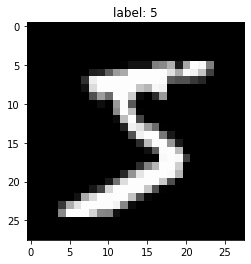

In [29]:
plt.figure()
plt.title(f"label: {label}")
plt.imshow(np.array(input), cmap="gray")
plt.show()

Aha, the handwriting of the digit "5" corresponds to the label "5", so we have 60000 grayscale images whose sizes are 28x28 and the corresponding numerical labels.

## Step 2: Input/Output Representation

For our model to process the image, it's more convenient to "flatten" the images to be a long vector instead of a 28x28 matrix.

In [30]:
input_reshaped = np.array(input).reshape(-1)

In [31]:
print(input_reshaped)
print(input_reshaped.shape)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

So instead of 28x28 images, we are working with 784-dimensional vectors. (28x28 = 784)

As for the output representation, remember that we had 1000-dimensional output for our ImageNet demo earlier. Now, we have the digit classification problem, meaning...

Q: What would our predictions look like, when the neural network produces it?
* A. "5" or something like that
* B. An image of the digit 5
* C. A 10-dimensional array

## Step 3: Differentiable Programming

Libraries like PyTorch, TensorFlow, Caffe, MXNet and more allow us to simplify training neural networks with more interpretable code. Differentiable programming libraries usually work with "tensors" which are basically the same as arrays, but they have a special property where differentiable operations are recorded into the variables. Easier to show this than tell:

In [32]:
input_tensor = torch.tensor(input_reshaped)

Q: What do you think input_tensor looks like?
* A. Basically same as input_reshaped
* B. Different from input_reshaped
* C. None of the above

In [33]:
print(input_tensor)
print(input_tensor.shape)

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
         18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 1

Now, we will instantiate our neural network. In PyTorch's language, producing predictions from a neural network (model) is a differentiable operation, which we will see soon.

## Step 4: Neural Network

In this step, we will instantiate a neural network using PyTorch's `nn.Sequential` class. `nn.Sequential` lets us express a sequence of differentiable operations quite gracefully.

In [34]:
model = nn.Sequential(
    nn.Linear(784, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
)

## Pop Quiz!

Q: What do you think `nn.Linear(784, 16)` is about?

* A. a matrix multiplication that reduces a 784-dimensional vector to a 16-dimensional vector
* B. a linear interpolation between a 784-dimensional vector and a 16-dimensional vector
* C. none of the above

Let's see what the output looks like when we put our 784-dimensional tensor through.

In [35]:
# forward() is basically the same as predict(), but it's says more explicitly that the operation is differentiable
pred_tensor = model.forward(input_tensor)

RuntimeError: expected scalar type Byte but found Float

Oops, looks like the data types are incompatible. Here come some dull/cryptic bits when working with differentiable programming libraries: you must make sure that the data types and input shapes are consistent.

In [36]:
pred_tensor = model.forward(input_tensor.float())

Whew! So we needed to massage our input image as follows:
* Turn the image into a 28x28 array
* Turn the 28x28 array in to a 784-dimensional array
* Turn the array in to a tensor
* Cast the data type of the tensor to float to be consistent with expected data type

Let's look at the shape of `pred_tensor`:

In [37]:
print(pred_tensor.shape)

torch.Size([10])


Q: Is there any difference from what you were expecting?

Now, let's look at what's inside `pred_tensor`.

Q: Do you think `pred_tensor` would be a "correct" prediction?

In [38]:
print(pred_tensor)

tensor([ -3.4802, -13.5976,   6.1866,  11.7319,   1.4448,  -2.5141,  -3.4041,
          8.9416,   3.4093,   5.3262], grad_fn=<AddBackward0>)


In [39]:
print(torch.argmax(pred_tensor))

tensor(3)


Of course not! Since the network is completely untrained and it has no idea what a digit 5 looks like.

## Step 5: Loss Function

As you see, initializing a NN and just producing a prediction doesn't do anything. We must provide a "training signal" to the network using a loss function, as discussed in the lecture.

In [40]:
label_tensor = torch.tensor(label)
print(torch.argmax(pred_tensor), label_tensor)

tensor(3) tensor(5)


So right now the neural network thinks the image is a "3". Of course, it has no idea what it's saying. Let's give it a feedback of a sort, expressed via a *loss function*.

In [41]:
# We won't go into details about what CrossEntropyLoss is, but just know that this is the correct loss
# for our task and current format of input/output representations
cross_entropy_loss = nn.CrossEntropyLoss()

In [43]:
# Another shape massaging, but I won't get into it too much. Once you wrangle tensors for long enough, 
# it becomes pretty clear.
loss = cross_entropy_loss.forward(pred_tensor.unsqueeze(0), label_tensor.unsqueeze(0))
print(loss)

tensor(14.3111, grad_fn=<NllLossBackward0>)


Aha, now we successfully quantified the performance of our current NN.

Q: Making an NN "better" would correspond to...
* A. Minimizing the value coming from `cross_entropy_loss.forward()`
* B. Maximizing the value coming from `cross_entropy_loss.forward()`
* C. None of the above


## Step 6: Optimization algorithm

The very last step for us is to use an optimization algorithm to optimize the loss value. How? Well, it's a pretty complex concept. For now, I'll present you PyTorch's beautifully elegant way to use optimization algorithms out-of-the-box.

In [44]:
optimizer = torch.optim.Adam(lr=3e-4, params=model.parameters())

Explanation:
* "Adam" is a widely popular optimization algorithm that has 10k+ citations. It's not perfect, but it's a great starting point.
* `lr` stands for learning rate. For now, I'm using some number according to my intuitive guess of what a good learning rate looks like.
* `params` specifies what I'm changing in order to make the loss function lower, hence the connections of our NN.

Optimizers are easy to use, if you forgive some arbitrary-looking steps.

In [45]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

Just for the demonstration of what that chunk of code just did, I'll redo the prediction and loss calculation steps.

In [46]:
pred_tensor = model.forward(input_tensor.float().reshape(1, -1))
loss = cross_entropy_loss.forward(pred_tensor, label_tensor.reshape(-1))
print(loss)

tensor(11.1902, grad_fn=<NllLossBackward0>)


Q: Note the differences in number. What do you think happened?
* A. The parameters of our NN got changed by optimizer
* B. The prediction from our NN got changed
* C. All of the above

If I did this many many times, my NN would know what the correct label is!

In [47]:
for _ in tqdm(range(1000)):
    # get the latest version of prediction
    pred_tensor = model.forward(input_tensor.float().reshape(1, -1))
    # compute loss based on predictions (note that label_tensor never changes!)
    loss = cross_entropy_loss.forward(pred_tensor, label_tensor.reshape(-1))
    # perform an optimization step, which mutates our NN
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # rinse and repeat 1000 times!

100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2430.26it/s]


In [48]:
print(loss)

tensor(0.0003, grad_fn=<NllLossBackward0>)


Wow, that's a pretty "small" number. Here's what our latest prediction looks like:

In [49]:
pred_tensor = model.forward(input_tensor.float().reshape(1, -1))
print(pred_tensor)
print(torch.argmax(pred_tensor), label_tensor.reshape(-1))

tensor([[ -9.5457,  -7.6440,  -0.2429,   3.1941,   3.6783,  13.1232,  -6.9873,
          -2.4683,   4.2729, -18.8467]], grad_fn=<AddmmBackward0>)
tensor(5) tensor([5])


That's a huge improvement from thinking it's a "3"!

## Putting it altogether

Thus far, for the sake of demonstration, we only used one example (image/label pair) to train our neural network. Of course, this is not super useful. For example, it never had the chance to see what other digits look like!

Ideally, we should use all of the 60000 digits to train a decent digit classifier. For the interest of time, though, we use only 100 digits for now. Forgive a few magic lines that I don't have time to get into, but believe that all of the 6 steps discussed above are still present.

In [51]:
def collate(examples):
    inputs = torch.stack([torch.tensor(np.array(input)).reshape(-1) for input, _ in examples], dim=0)
    labels = torch.tensor([label for _, label in examples])
    return inputs, labels    

subset = Subset(dataset, np.arange(100))
data_loader = DataLoader(subset, batch_size=100, collate_fn=collate)

model = nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10),
)
optimizer = torch.optim.Adam(lr=3e-4, params=model.parameters())

Q: Look at the way we instantiated `model` just now. Why would I want to use 1024 as the layer size now?

In [55]:
for _ in tqdm(range(100)):
    epoch_loss = 0.
    for example in data_loader:
        input, label = example
        input = input.float() / 255.
        
        # gpu acceleration
        model = model.cuda()
        input_tensor = input_tensor.cuda()
        label_tensor = label_tensor.cuda()
        
        # get the latest version of prediction
        pred_tensor = model.forward(input_tensor)

        # compute loss based on predictions (note that label_tensor never changes!)
        loss = cross_entropy_loss.forward(pred_tensor, label_tensor.reshape(-1))
        
        # perform an optimization step, which mutates our NN
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data
    epoch_loss /= len(subset)

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 203.53it/s]


In [56]:
# for our case, inference doesn't need gpu acceleration
model = model.cpu()
input_tensor = input_tensor.cpu()
label_tensor = label_tensor.cpu()

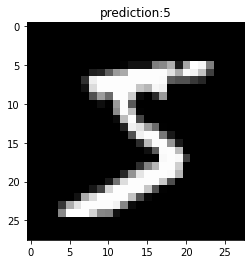

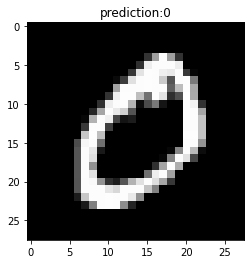

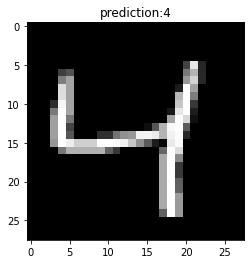

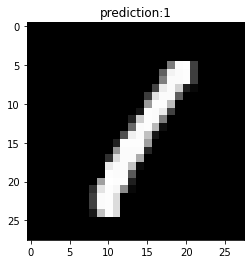

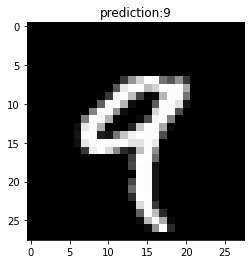

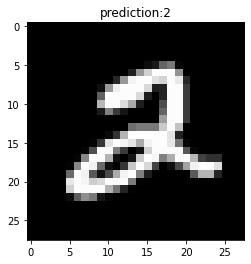

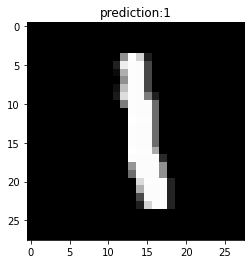

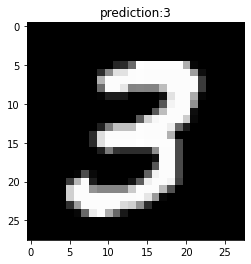

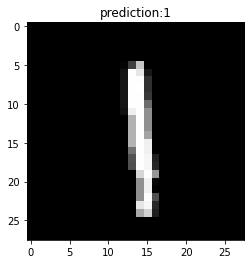

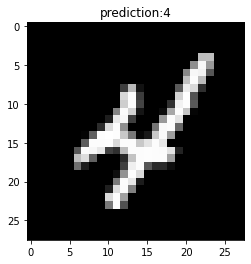

In [57]:
for i in range(10):
    input, label = subset[i]
    input_array = np.array(input)
    input_reshaped = np.array(input).reshape(1, -1)
    input_tensor = torch.tensor(input_reshaped).float() / 255.
    pred_tensor = model.forward(input_tensor)
    prob_tensor = torch.softmax(pred_tensor, dim=1)
    
    plt.figure()
    plt.imshow(input_array, cmap="gray")
    plt.title(f"prediction:{torch.argmax(prob_tensor).item()}")
    plt.show()

# But Before You Go...

Is our NN actually useful in the wild? i.e. if I show more digit images that were NOT used during training, what happens?

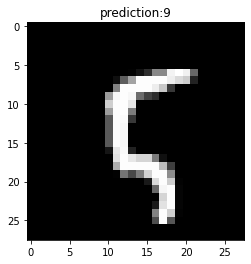

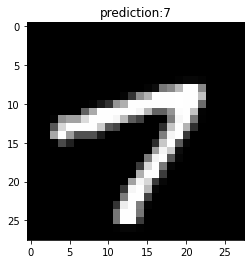

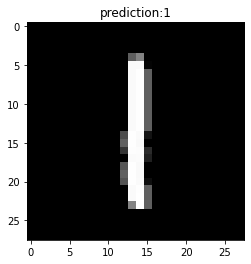

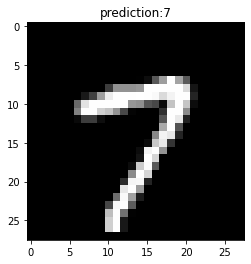

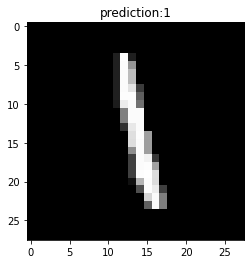

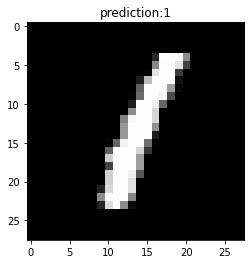

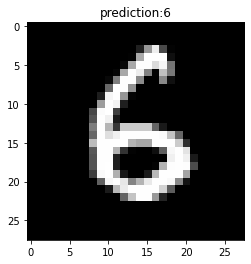

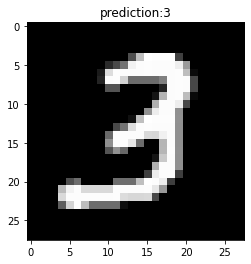

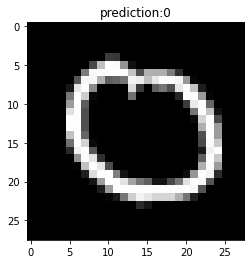

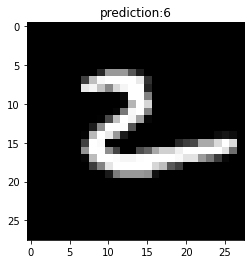

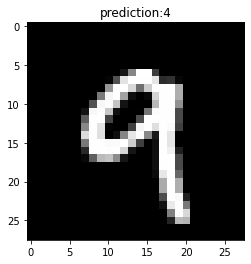

In [34]:
for i in np.arange(100, 111):
    input, label = dataset[i]
    input_array = np.array(input)
    input_reshaped = np.array(input).reshape(1, -1)
    input_tensor = torch.tensor(input_reshaped).float() / 255.
    pred_tensor = model.forward(input_tensor)
    prob_tensor = torch.softmax(pred_tensor, dim=1)
    
    plt.figure()
    plt.imshow(input_array, cmap="gray")
    plt.title(f"prediction:{torch.argmax(prob_tensor).item()}")
#     print(torch.argmax(pred_tensor), label)

Lots of errors start showing up. This is called *overfitting*. We won't be getting too much in detail about this, but be aware that for your NN to be useful at inference time, you need more "general" performance, usually achieved by e.g.:
* Using more data
* Using sparser architectures
* Using augmentations
* Using better *hyperparameters*